# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

## Solutions by Piotr Kubala

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [4]:
import numpy as np
from matplotlib import pyplot
from matplotlib import pyplot as plt
from tqdm import tqdm
from open_atmos_jupyter_utils import show_plot

In [5]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [6]:
x_min = -100
x_max = 300

In [7]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

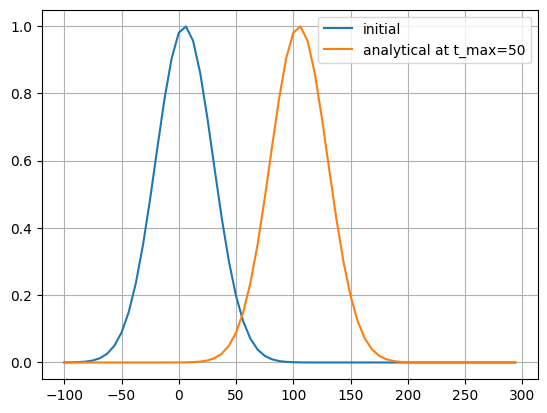

In [8]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [9]:
F = lambda psi_1, psi_2, c_const: ((c_const + np.abs(c_const)) * psi_1 + (c_const - np.abs(c_const)) * psi_2) * 0.5

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [10]:
class One:
    def __radd__(self, other_slice):
        return slice(other_slice.start + 1, other_slice.stop + 1, other_slice.step)
        
    def __rsub__(self, other_slice):
        return slice(other_slice.start - 1, other_slice.stop - 1, other_slice.step)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

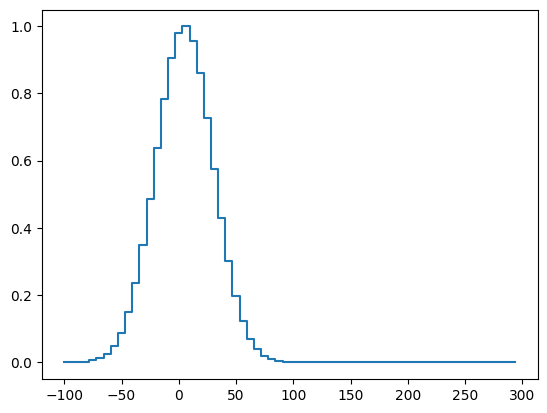

In [11]:
psi = psi_0(x)
nt = 64
dt = t_max / nt
c_const = u * dt / dx

one = One()
psi_slice_center = slice(1, nx - 2)

psi_slice_before = psi_slice_center - one
psi_slice_after = psi_slice_center + one

plt.step(x, psi, label=f't=0', where='mid')

for _ in range(nt):
    psi_before = psi[psi_slice_before]
    psi_after = psi[psi_slice_after]
    psi_center = psi[psi_slice_center]
    # print(psi_center.shape, psi_before.shape, psi_after.shape)

    psi[psi_slice_center] -= F(psi_center, psi_after, c_const) - F(psi_before, psi_center, c_const)

C = c_const

**7. comparing analytic and numerical solutions**

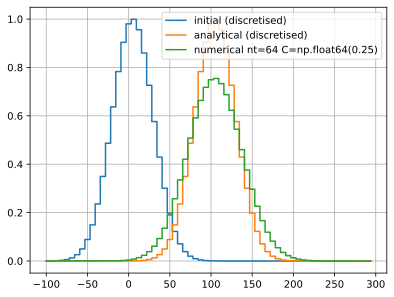

In [12]:
plt.step(x, psi_0(x), label='initial (discretised)', where='mid')
plt.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
plt.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
plt.legend()
plt.grid()
show_plot()

# The goal

The goal of the analysis is to compare the analytical solution with the numerical one using the RMSE metric for a set of $dx$ values and a fixed Courant number.

Then, the entire process is repeated for a set of Courant numbers and all the results are visualised.

# Simulation code
Code performing the numerical computations needed to provide an approximate solution to the advection equation using the upwind scheme for a given constant velocity, Courant number and spatial discretisation.

In [13]:
def perform_simulation(x: np.ndarray, u: float, c_const: float, dx: float) -> np.ndarray:
    psi = psi_0(x)
    dt = c_const * dx / u
    nt = round(t_max / dt)
    nx = len(x)
    psi_slice_center = slice(1, nx - 2)
    psi_slice_before = psi_slice_center - one
    psi_slice_after = psi_slice_center + one

    for _ in range(nt):
        psi_before = psi[psi_slice_before]
        psi_after = psi[psi_slice_after]
        psi_center = psi[psi_slice_center]
        psi[psi_slice_center] -= F(psi_center, psi_after, c_const) - F(psi_before, psi_center, c_const)

    return psi

# RMSE

The root mean square error (RMSE) is a measure defined as the square root of the average of the squared differences between the analytical and numerical solutions for a given time.

$$
\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(\psi_{\text{analytic}}(x_i, t) - \psi_{\text{numerical}}(x_i, t))^2}
$$

In [14]:
def rmse(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.mean((x - y)**2))

# Analysis approach
For a given Courant number and a list of $dx$ values, we want to compute the numerical solution as well as the analytical one and then calculate the RMSE. The result is a list of RMSE values for each $dx$ value.

Recall that the Courant number is defined as $C = u\frac{\Delta t}{\Delta x}$, so we can rewrite it as $\Delta t = \frac{C\Delta x}{u}$ which allows us to calculate the time step for a given Courant number and spatial discretisation.

In [15]:
def get_errors(u: float, c_const: float, dx: np.ndarray) -> np.ndarray:
    errors = np.zeros_like(dx)
    for i, dx_val in enumerate(dx):
        nx = round((x_max - x_min) / dx_val)
        x = np.linspace(x_min, x_max, nx, endpoint=False)
        psi_num = perform_simulation(x, u, c_const, dx_val)
        psi_analytical = psi_0(x - u * t_max)
        error_val = rmse(psi_num, psi_analytical)
        errors[i] = error_val

    return np.array(errors)

# Plotting
The results are visualised using a plot with RMSE on the y-axis and $dx$ on the x-axis. For each Courant number, a separate curve is plotted.

100%|██████████| 5/5 [00:00<00:00, 10.17it/s]


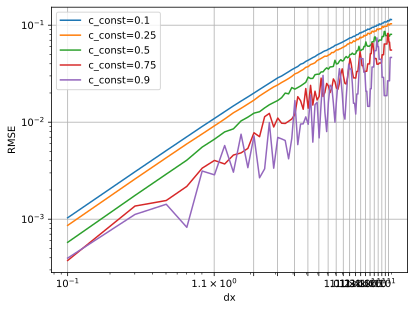

In [17]:
min_dx = 0.1
max_dx = 20

dx_values = np.linspace(min_dx, max_dx, 100)
u = 1

for c_const in tqdm([0.1, 0.25, 0.5, 0.75, 0.9]):
    errors = get_errors(u, c_const, dx_values)
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(dx_values, errors, label=f'{c_const=}')
    plt.xlabel('dx')
    plt.ylabel('RMSE')
    plt.xticks(np.arange(min_dx, max_dx, 1))
    plt.legend()
    plt.grid()
show_plot()

As can be observed, the RMSE decreases with decreasing $dx$ values, and their relationship seems to be linear for sufficiently small $dx$ values. That means that the convergence rate of the upwind scheme is first order.

It's worth noting that the Courant number is a crucial parameter in the upwind scheme. If it is too large, the numerical solution may become unstable, however the RMSE grows more rapidly when the Courant number is small (all Courant numbers are less than 1).